<a href="https://colab.research.google.com/github/mahsadadkhah/price-classification/blob/master/classification_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports **

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Read Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/mobile_price.zip /content/

In [ ]:
!unzip /content/mobile_price.zip

Archive:  /content/mobile_price.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df = pd.read_csv('/content/train.csv')
X = df.drop('price_range', axis=1)
y = df['price_range']

In [ ]:
df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


## Split

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=42)

## Preprocess

In [ ]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

## Dataloader

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, 20, True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=200)

# **Model 🧠**

In [ ]:
num_feats = 20
num_class = 4
h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      # nn.Dropout(0.5),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

In [ ]:
model[0].bias

Parameter containing:
tensor([ 0.1531, -0.1257,  0.1399,  0.2030, -0.0195,  0.1256,  0.2010,  0.2025,
        -0.0034, -0.1986,  0.1044,  0.0959,  0.0936,  0.1636, -0.1977, -0.0075,
         0.0699, -0.2144,  0.1890,  0.1744,  0.1394, -0.0483, -0.0713,  0.0389,
         0.1351,  0.1066,  0.0297,  0.1071,  0.0187, -0.0738,  0.0644, -0.0159,
        -0.0306,  0.2022, -0.2154, -0.0436, -0.0276, -0.1047,  0.0549,  0.1874,
        -0.1608,  0.1737,  0.1984,  0.1887,  0.0556,  0.0252, -0.1097, -0.0062,
         0.1005,  0.1677, -0.1517, -0.1228,  0.1635, -0.1139, -0.1122, -0.0835,
        -0.1048, -0.2199,  0.0183,  0.0399, -0.0152,  0.0290,  0.1810,  0.1995],
       requires_grad=True)



## *   torch.nn
## *   Dropout



# **Loss & Optimizer ⚖️**

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, nesterov=True,
                      weight_decay=1e-4)


# **Device ⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=4).to(device)
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())

      tepoch.set_postfix(loss = loss_train.avg,
                         accuracy = 100*acc_train.compute().item() )

  return model, loss_train.avg, acc_train.compute().item()


In [ ]:
def evaluate(model, valid_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=4).to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute()

# **Train**

In [ ]:
num_epochs = 100

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
  model ,loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  loss_valid, acc_valid = evaluate(model,
                                   valid_loader,
                                   loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  print(f'Valid: Loss = {loss_valid:.4}, Accuracy = {acc_valid:.4}')
  print()


Epoch 0: 100%|██████████| 70/70 [00:00<00:00, 120.73batch/s, accuracy=40.4, loss=1.3]


Valid: Loss = 1.095, Accuracy = 0.5667



Epoch 1: 100%|██████████| 70/70 [00:00<00:00, 118.98batch/s, accuracy=68.1, loss=0.802]


Valid: Loss = 0.5516, Accuracy = 0.9



Epoch 2: 100%|██████████| 70/70 [00:00<00:00, 117.00batch/s, accuracy=88.8, loss=0.432]


Valid: Loss = 0.3336, Accuracy = 0.925



Epoch 3: 100%|██████████| 70/70 [00:00<00:00, 112.40batch/s, accuracy=92.5, loss=0.282]


Valid: Loss = 0.2611, Accuracy = 0.9



Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 107.68batch/s, accuracy=94.1, loss=0.206]


Valid: Loss = 0.22, Accuracy = 0.9283



Epoch 5: 100%|██████████| 70/70 [00:00<00:00, 108.59batch/s, accuracy=95.5, loss=0.161]


Valid: Loss = 0.2004, Accuracy = 0.9267



Epoch 6: 100%|██████████| 70/70 [00:00<00:00, 109.32batch/s, accuracy=96, loss=0.134]


Valid: Loss = 0.19, Accuracy = 0.9117



Epoch 7: 100%|██████████| 70/70 [00:00<00:00, 106.47batch/s, accuracy=96.4, loss=0.118]


Valid: Loss = 0.1843, Accuracy = 0.92



Epoch 8: 100%|██████████| 70/70 [00:00<00:00, 115.91batch/s, accuracy=97.4, loss=0.0963]


Valid: Loss = 0.2038, Accuracy = 0.9167



Epoch 9: 100%|██████████| 70/70 [00:00<00:00, 109.27batch/s, accuracy=98.1, loss=0.0808]


Valid: Loss = 0.1662, Accuracy = 0.925



Epoch 10: 100%|██████████| 70/70 [00:00<00:00, 117.95batch/s, accuracy=97.9, loss=0.079]


Valid: Loss = 0.1746, Accuracy = 0.9183



Epoch 11: 100%|██████████| 70/70 [00:00<00:00, 115.16batch/s, accuracy=98.6, loss=0.0642]


Valid: Loss = 0.1866, Accuracy = 0.92



Epoch 12: 100%|██████████| 70/70 [00:00<00:00, 118.54batch/s, accuracy=98.4, loss=0.0613]


Valid: Loss = 0.1854, Accuracy = 0.9183



Epoch 13: 100%|██████████| 70/70 [00:00<00:00, 124.31batch/s, accuracy=98.7, loss=0.0523]


Valid: Loss = 0.2001, Accuracy = 0.9183



Epoch 14: 100%|██████████| 70/70 [00:00<00:00, 113.24batch/s, accuracy=99.4, loss=0.0421]


Valid: Loss = 0.1846, Accuracy = 0.93



Epoch 15: 100%|██████████| 70/70 [00:00<00:00, 125.42batch/s, accuracy=99.3, loss=0.0406]


Valid: Loss = 0.1675, Accuracy = 0.9183



Epoch 16: 100%|██████████| 70/70 [00:00<00:00, 118.96batch/s, accuracy=99.6, loss=0.0328]


Valid: Loss = 0.1631, Accuracy = 0.9267



Epoch 17: 100%|██████████| 70/70 [00:00<00:00, 119.01batch/s, accuracy=99.8, loss=0.0279]


Valid: Loss = 0.1784, Accuracy = 0.9233



Epoch 18: 100%|██████████| 70/70 [00:00<00:00, 114.44batch/s, accuracy=99.9, loss=0.0256]


Valid: Loss = 0.1893, Accuracy = 0.9217



Epoch 19: 100%|██████████| 70/70 [00:00<00:00, 106.04batch/s, accuracy=99.7, loss=0.0225]


Valid: Loss = 0.1881, Accuracy = 0.92



Epoch 20: 100%|██████████| 70/70 [00:00<00:00, 98.93batch/s, accuracy=99.9, loss=0.0185]


Valid: Loss = 0.1872, Accuracy = 0.9183



Epoch 21: 100%|██████████| 70/70 [00:00<00:00, 104.19batch/s, accuracy=100, loss=0.0176]


Valid: Loss = 0.1975, Accuracy = 0.92



Epoch 22: 100%|██████████| 70/70 [00:00<00:00, 117.23batch/s, accuracy=99.9, loss=0.0151]


Valid: Loss = 0.1832, Accuracy = 0.9283



Epoch 23: 100%|██████████| 70/70 [00:00<00:00, 123.62batch/s, accuracy=100, loss=0.0136]


Valid: Loss = 0.1965, Accuracy = 0.9183



Epoch 24: 100%|██████████| 70/70 [00:00<00:00, 118.65batch/s, accuracy=100, loss=0.0118]


Valid: Loss = 0.1962, Accuracy = 0.915



Epoch 25: 100%|██████████| 70/70 [00:00<00:00, 120.96batch/s, accuracy=100, loss=0.0116]


Valid: Loss = 0.1912, Accuracy = 0.9267



Epoch 26: 100%|██████████| 70/70 [00:00<00:00, 120.08batch/s, accuracy=100, loss=0.0101]


Valid: Loss = 0.1892, Accuracy = 0.9233



Epoch 27: 100%|██████████| 70/70 [00:00<00:00, 123.45batch/s, accuracy=100, loss=0.00921]


Valid: Loss = 0.2019, Accuracy = 0.925



Epoch 28: 100%|██████████| 70/70 [00:00<00:00, 95.43batch/s, accuracy=100, loss=0.00903]


Valid: Loss = 0.2113, Accuracy = 0.9183



Epoch 29: 100%|██████████| 70/70 [00:00<00:00, 91.60batch/s, accuracy=100, loss=0.00856]


Valid: Loss = 0.2025, Accuracy = 0.9183



Epoch 30: 100%|██████████| 70/70 [00:01<00:00, 67.97batch/s, accuracy=100, loss=0.00755]


Valid: Loss = 0.2121, Accuracy = 0.9217



Epoch 31: 100%|██████████| 70/70 [00:00<00:00, 71.06batch/s, accuracy=100, loss=0.00722]


Valid: Loss = 0.2109, Accuracy = 0.92



Epoch 32: 100%|██████████| 70/70 [00:01<00:00, 68.24batch/s, accuracy=100, loss=0.00689]


Valid: Loss = 0.2011, Accuracy = 0.92



Epoch 33: 100%|██████████| 70/70 [00:00<00:00, 123.29batch/s, accuracy=100, loss=0.00637]


Valid: Loss = 0.2073, Accuracy = 0.925



Epoch 34: 100%|██████████| 70/70 [00:00<00:00, 120.44batch/s, accuracy=100, loss=0.00635]


Valid: Loss = 0.2088, Accuracy = 0.9233



Epoch 35: 100%|██████████| 70/70 [00:00<00:00, 110.95batch/s, accuracy=100, loss=0.00599]


Valid: Loss = 0.2014, Accuracy = 0.92



Epoch 36: 100%|██████████| 70/70 [00:00<00:00, 105.14batch/s, accuracy=100, loss=0.00562]


Valid: Loss = 0.2109, Accuracy = 0.9233



Epoch 37: 100%|██████████| 70/70 [00:00<00:00, 118.54batch/s, accuracy=100, loss=0.00531]


Valid: Loss = 0.2093, Accuracy = 0.925



Epoch 38: 100%|██████████| 70/70 [00:00<00:00, 119.35batch/s, accuracy=100, loss=0.00505]


Valid: Loss = 0.2209, Accuracy = 0.915



Epoch 39: 100%|██████████| 70/70 [00:00<00:00, 116.61batch/s, accuracy=100, loss=0.00507]


Valid: Loss = 0.2132, Accuracy = 0.92



Epoch 40: 100%|██████████| 70/70 [00:00<00:00, 125.56batch/s, accuracy=100, loss=0.00482]


Valid: Loss = 0.2173, Accuracy = 0.9183



Epoch 41: 100%|██████████| 70/70 [00:00<00:00, 113.71batch/s, accuracy=100, loss=0.00466]


Valid: Loss = 0.2091, Accuracy = 0.9217



Epoch 42: 100%|██████████| 70/70 [00:00<00:00, 117.85batch/s, accuracy=100, loss=0.0044]


Valid: Loss = 0.2195, Accuracy = 0.92



Epoch 43: 100%|██████████| 70/70 [00:00<00:00, 117.09batch/s, accuracy=100, loss=0.00408]


Valid: Loss = 0.2178, Accuracy = 0.9217



Epoch 44: 100%|██████████| 70/70 [00:00<00:00, 122.88batch/s, accuracy=100, loss=0.00401]


Valid: Loss = 0.2163, Accuracy = 0.92



Epoch 45: 100%|██████████| 70/70 [00:00<00:00, 126.73batch/s, accuracy=100, loss=0.00388]


Valid: Loss = 0.2233, Accuracy = 0.9217



Epoch 46: 100%|██████████| 70/70 [00:00<00:00, 123.21batch/s, accuracy=100, loss=0.00378]


Valid: Loss = 0.2213, Accuracy = 0.9183



Epoch 47: 100%|██████████| 70/70 [00:00<00:00, 119.52batch/s, accuracy=100, loss=0.00363]


Valid: Loss = 0.2262, Accuracy = 0.9183



Epoch 48: 100%|██████████| 70/70 [00:00<00:00, 126.15batch/s, accuracy=100, loss=0.00348]


Valid: Loss = 0.2243, Accuracy = 0.9233



Epoch 49: 100%|██████████| 70/70 [00:00<00:00, 115.02batch/s, accuracy=100, loss=0.00348]


Valid: Loss = 0.2216, Accuracy = 0.9217



Epoch 50: 100%|██████████| 70/70 [00:00<00:00, 114.05batch/s, accuracy=100, loss=0.00328]


Valid: Loss = 0.2219, Accuracy = 0.92



Epoch 51: 100%|██████████| 70/70 [00:00<00:00, 76.34batch/s, accuracy=100, loss=0.00325]


Valid: Loss = 0.224, Accuracy = 0.9167



Epoch 52: 100%|██████████| 70/70 [00:01<00:00, 46.07batch/s, accuracy=100, loss=0.00314]


Valid: Loss = 0.2282, Accuracy = 0.9217



Epoch 53: 100%|██████████| 70/70 [00:01<00:00, 47.92batch/s, accuracy=100, loss=0.00309]


Valid: Loss = 0.2257, Accuracy = 0.915



Epoch 54: 100%|██████████| 70/70 [00:02<00:00, 33.51batch/s, accuracy=100, loss=0.00298]


Valid: Loss = 0.2299, Accuracy = 0.9167



Epoch 55: 100%|██████████| 70/70 [00:01<00:00, 56.60batch/s, accuracy=100, loss=0.00292]


Valid: Loss = 0.2247, Accuracy = 0.9183



Epoch 56: 100%|██████████| 70/70 [00:01<00:00, 55.06batch/s, accuracy=100, loss=0.00284]


Valid: Loss = 0.23, Accuracy = 0.9183



Epoch 57: 100%|██████████| 70/70 [00:01<00:00, 51.88batch/s, accuracy=100, loss=0.00279]


Valid: Loss = 0.2299, Accuracy = 0.92



Epoch 58: 100%|██████████| 70/70 [00:01<00:00, 51.93batch/s, accuracy=100, loss=0.0027]


Valid: Loss = 0.2303, Accuracy = 0.9167



Epoch 59: 100%|██████████| 70/70 [00:01<00:00, 41.48batch/s, accuracy=100, loss=0.00266]


Valid: Loss = 0.2283, Accuracy = 0.9183



Epoch 60: 100%|██████████| 70/70 [00:01<00:00, 59.18batch/s, accuracy=100, loss=0.00262]


Valid: Loss = 0.2308, Accuracy = 0.9183



Epoch 61: 100%|██████████| 70/70 [00:01<00:00, 50.18batch/s, accuracy=100, loss=0.00249]


Valid: Loss = 0.2313, Accuracy = 0.92



Epoch 62: 100%|██████████| 70/70 [00:01<00:00, 52.24batch/s, accuracy=100, loss=0.00247]


Valid: Loss = 0.2315, Accuracy = 0.9167



Epoch 63: 100%|██████████| 70/70 [00:01<00:00, 40.48batch/s, accuracy=100, loss=0.00241]


Valid: Loss = 0.2301, Accuracy = 0.92



Epoch 64: 100%|██████████| 70/70 [00:01<00:00, 43.98batch/s, accuracy=100, loss=0.00242]


Valid: Loss = 0.2297, Accuracy = 0.9183



Epoch 65: 100%|██████████| 70/70 [00:01<00:00, 36.38batch/s, accuracy=100, loss=0.00233]


Valid: Loss = 0.2295, Accuracy = 0.92



Epoch 66: 100%|██████████| 70/70 [00:00<00:00, 108.81batch/s, accuracy=100, loss=0.0023]


Valid: Loss = 0.2314, Accuracy = 0.9167



Epoch 67: 100%|██████████| 70/70 [00:00<00:00, 119.00batch/s, accuracy=100, loss=0.00227]


Valid: Loss = 0.2319, Accuracy = 0.92



Epoch 68: 100%|██████████| 70/70 [00:00<00:00, 118.54batch/s, accuracy=100, loss=0.00223]


Valid: Loss = 0.2313, Accuracy = 0.9167



Epoch 69: 100%|██████████| 70/70 [00:00<00:00, 79.86batch/s, accuracy=100, loss=0.00215]


Valid: Loss = 0.2365, Accuracy = 0.915



Epoch 70: 100%|██████████| 70/70 [00:01<00:00, 44.13batch/s, accuracy=100, loss=0.00216]


Valid: Loss = 0.2316, Accuracy = 0.92



Epoch 71: 100%|██████████| 70/70 [00:01<00:00, 44.51batch/s, accuracy=100, loss=0.0021]


Valid: Loss = 0.236, Accuracy = 0.9183



Epoch 72: 100%|██████████| 70/70 [00:01<00:00, 50.54batch/s, accuracy=100, loss=0.00207]


Valid: Loss = 0.2349, Accuracy = 0.9167



Epoch 73: 100%|██████████| 70/70 [00:00<00:00, 74.96batch/s, accuracy=100, loss=0.002]


Valid: Loss = 0.2344, Accuracy = 0.915



Epoch 74: 100%|██████████| 70/70 [00:00<00:00, 82.64batch/s, accuracy=100, loss=0.00203]


Valid: Loss = 0.2378, Accuracy = 0.9167



Epoch 75: 100%|██████████| 70/70 [00:01<00:00, 65.51batch/s, accuracy=100, loss=0.00199]


Valid: Loss = 0.2367, Accuracy = 0.9167



Epoch 76: 100%|██████████| 70/70 [00:01<00:00, 52.26batch/s, accuracy=100, loss=0.00192]


Valid: Loss = 0.2368, Accuracy = 0.9167



Epoch 77: 100%|██████████| 70/70 [00:01<00:00, 65.38batch/s, accuracy=100, loss=0.00193]


Valid: Loss = 0.2366, Accuracy = 0.9183



Epoch 78: 100%|██████████| 70/70 [00:00<00:00, 100.07batch/s, accuracy=100, loss=0.00188]


Valid: Loss = 0.239, Accuracy = 0.915



Epoch 79: 100%|██████████| 70/70 [00:00<00:00, 112.10batch/s, accuracy=100, loss=0.00186]


Valid: Loss = 0.2383, Accuracy = 0.9183



Epoch 80: 100%|██████████| 70/70 [00:00<00:00, 106.16batch/s, accuracy=100, loss=0.00185]


Valid: Loss = 0.2388, Accuracy = 0.9183



Epoch 81: 100%|██████████| 70/70 [00:00<00:00, 121.02batch/s, accuracy=100, loss=0.00182]


Valid: Loss = 0.2392, Accuracy = 0.915



Epoch 82: 100%|██████████| 70/70 [00:00<00:00, 120.95batch/s, accuracy=100, loss=0.00179]


Valid: Loss = 0.239, Accuracy = 0.9183



Epoch 83: 100%|██████████| 70/70 [00:00<00:00, 119.10batch/s, accuracy=100, loss=0.00177]


Valid: Loss = 0.2395, Accuracy = 0.9167



Epoch 84: 100%|██████████| 70/70 [00:00<00:00, 121.05batch/s, accuracy=100, loss=0.00174]


Valid: Loss = 0.2416, Accuracy = 0.9133



Epoch 85: 100%|██████████| 70/70 [00:00<00:00, 127.32batch/s, accuracy=100, loss=0.00173]


Valid: Loss = 0.2424, Accuracy = 0.9183



Epoch 86: 100%|██████████| 70/70 [00:00<00:00, 115.69batch/s, accuracy=100, loss=0.00172]


Valid: Loss = 0.2414, Accuracy = 0.915



Epoch 87: 100%|██████████| 70/70 [00:01<00:00, 62.78batch/s, accuracy=100, loss=0.00169]


Valid: Loss = 0.2403, Accuracy = 0.9183



Epoch 88: 100%|██████████| 70/70 [00:01<00:00, 61.97batch/s, accuracy=100, loss=0.00166]


Valid: Loss = 0.2414, Accuracy = 0.9183



Epoch 89: 100%|██████████| 70/70 [00:01<00:00, 57.39batch/s, accuracy=100, loss=0.00162]


Valid: Loss = 0.24, Accuracy = 0.9167



Epoch 90: 100%|██████████| 70/70 [00:00<00:00, 74.91batch/s, accuracy=100, loss=0.00163]


Valid: Loss = 0.2434, Accuracy = 0.9167



Epoch 91: 100%|██████████| 70/70 [00:00<00:00, 106.92batch/s, accuracy=100, loss=0.00162]


Valid: Loss = 0.2438, Accuracy = 0.92



Epoch 92: 100%|██████████| 70/70 [00:00<00:00, 105.43batch/s, accuracy=100, loss=0.0016]


Valid: Loss = 0.243, Accuracy = 0.915



Epoch 93: 100%|██████████| 70/70 [00:00<00:00, 117.04batch/s, accuracy=100, loss=0.0016]


Valid: Loss = 0.2456, Accuracy = 0.9167



Epoch 94: 100%|██████████| 70/70 [00:00<00:00, 123.78batch/s, accuracy=100, loss=0.00156]


Valid: Loss = 0.2437, Accuracy = 0.92



Epoch 95: 100%|██████████| 70/70 [00:00<00:00, 115.40batch/s, accuracy=100, loss=0.00155]


Valid: Loss = 0.2424, Accuracy = 0.9183



Epoch 96: 100%|██████████| 70/70 [00:00<00:00, 116.70batch/s, accuracy=100, loss=0.00155]


Valid: Loss = 0.2421, Accuracy = 0.9183



Epoch 97: 100%|██████████| 70/70 [00:00<00:00, 116.88batch/s, accuracy=100, loss=0.00151]


Valid: Loss = 0.2436, Accuracy = 0.915



Epoch 98: 100%|██████████| 70/70 [00:00<00:00, 70.67batch/s, accuracy=100, loss=0.0015]


Valid: Loss = 0.2443, Accuracy = 0.9183



Epoch 99: 100%|██████████| 70/70 [00:01<00:00, 68.44batch/s, accuracy=100, loss=0.00148]


Valid: Loss = 0.2445, Accuracy = 0.92



In [ ]:
num_epochs = 100

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)

  loss_valid, acc_valid = evaluate(model,
                                   valid_loader,
                                   loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  print(f'Valid: Loss={loss_valid:.4}, Accuracy={acc_valid:.4}\n')

Epoch 0: 100%|██████████| 70/70 [00:00<00:00, 92.56batch/s, accuracy=48.6, loss=1.29]


Valid: Loss=1.08, Accuracy=0.665



Epoch 1: 100%|██████████| 70/70 [00:00<00:00, 86.90batch/s, accuracy=74.3, loss=0.753]


Valid: Loss=0.5165, Accuracy=0.8183



Epoch 2: 100%|██████████| 70/70 [00:00<00:00, 88.29batch/s, accuracy=87.9, loss=0.404]


Valid: Loss=0.3183, Accuracy=0.9033



Epoch 3: 100%|██████████| 70/70 [00:00<00:00, 98.93batch/s, accuracy=93.3, loss=0.257]


Valid: Loss=0.2408, Accuracy=0.9133



Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 90.38batch/s, accuracy=94.2, loss=0.193]


Valid: Loss=0.2114, Accuracy=0.915



Epoch 5: 100%|██████████| 70/70 [00:00<00:00, 90.01batch/s, accuracy=96.1, loss=0.148]


Valid: Loss=0.2005, Accuracy=0.91



Epoch 6: 100%|██████████| 70/70 [00:00<00:00, 98.69batch/s, accuracy=96.4, loss=0.129]


Valid: Loss=0.2112, Accuracy=0.9033



Epoch 7: 100%|██████████| 70/70 [00:00<00:00, 93.45batch/s, accuracy=96.8, loss=0.108]


Valid: Loss=0.1696, Accuracy=0.9217



Epoch 8: 100%|██████████| 70/70 [00:00<00:00, 95.39batch/s, accuracy=98.1, loss=0.0861]


Valid: Loss=0.1772, Accuracy=0.9283



Epoch 9: 100%|██████████| 70/70 [00:00<00:00, 97.70batch/s, accuracy=98, loss=0.0762]


Valid: Loss=0.1811, Accuracy=0.9067



Epoch 10: 100%|██████████| 70/70 [00:00<00:00, 92.74batch/s, accuracy=98.4, loss=0.0675]


Valid: Loss=0.1855, Accuracy=0.9167



Epoch 11: 100%|██████████| 70/70 [00:00<00:00, 94.18batch/s, accuracy=98.8, loss=0.061]


Valid: Loss=0.193, Accuracy=0.9167



Epoch 12: 100%|██████████| 70/70 [00:00<00:00, 96.68batch/s, accuracy=99.1, loss=0.0538]


Valid: Loss=0.1734, Accuracy=0.9183



Epoch 13: 100%|██████████| 70/70 [00:00<00:00, 97.58batch/s, accuracy=99.4, loss=0.0421]


Valid: Loss=0.1884, Accuracy=0.92



Epoch 14: 100%|██████████| 70/70 [00:00<00:00, 94.48batch/s, accuracy=99.4, loss=0.0407]


Valid: Loss=0.1722, Accuracy=0.92



Epoch 15: 100%|██████████| 70/70 [00:00<00:00, 95.23batch/s, accuracy=99.9, loss=0.0322]


Valid: Loss=0.1796, Accuracy=0.9233



Epoch 16: 100%|██████████| 70/70 [00:00<00:00, 101.84batch/s, accuracy=99.9, loss=0.0298]


Valid: Loss=0.1743, Accuracy=0.93



Epoch 17: 100%|██████████| 70/70 [00:00<00:00, 99.79batch/s, accuracy=100, loss=0.025]


Valid: Loss=0.1739, Accuracy=0.92



Epoch 18: 100%|██████████| 70/70 [00:00<00:00, 83.89batch/s, accuracy=100, loss=0.022]


Valid: Loss=0.1738, Accuracy=0.9183



Epoch 19: 100%|██████████| 70/70 [00:00<00:00, 96.67batch/s, accuracy=99.8, loss=0.0194]


Valid: Loss=0.1783, Accuracy=0.9217



Epoch 20: 100%|██████████| 70/70 [00:00<00:00, 102.58batch/s, accuracy=100, loss=0.0159]


Valid: Loss=0.1844, Accuracy=0.915



Epoch 21: 100%|██████████| 70/70 [00:00<00:00, 94.26batch/s, accuracy=100, loss=0.015]


Valid: Loss=0.1936, Accuracy=0.91



Epoch 22: 100%|██████████| 70/70 [00:00<00:00, 89.96batch/s, accuracy=100, loss=0.0143]


Valid: Loss=0.183, Accuracy=0.9233



Epoch 23: 100%|██████████| 70/70 [00:00<00:00, 85.78batch/s, accuracy=100, loss=0.012]


Valid: Loss=0.1835, Accuracy=0.9217



Epoch 24: 100%|██████████| 70/70 [00:00<00:00, 100.96batch/s, accuracy=100, loss=0.012]


Valid: Loss=0.1877, Accuracy=0.925



Epoch 25: 100%|██████████| 70/70 [00:00<00:00, 100.47batch/s, accuracy=100, loss=0.011]


Valid: Loss=0.1969, Accuracy=0.9117



Epoch 26: 100%|██████████| 70/70 [00:00<00:00, 90.15batch/s, accuracy=100, loss=0.0099]


Valid: Loss=0.1881, Accuracy=0.9167



Epoch 27: 100%|██████████| 70/70 [00:00<00:00, 98.67batch/s, accuracy=100, loss=0.00889]


Valid: Loss=0.1871, Accuracy=0.9233



Epoch 28: 100%|██████████| 70/70 [00:00<00:00, 100.79batch/s, accuracy=100, loss=0.00861]


Valid: Loss=0.1934, Accuracy=0.9217



Epoch 29: 100%|██████████| 70/70 [00:00<00:00, 99.67batch/s, accuracy=100, loss=0.00799]


Valid: Loss=0.1904, Accuracy=0.9217



Epoch 30: 100%|██████████| 70/70 [00:00<00:00, 86.58batch/s, accuracy=100, loss=0.00733]


Valid: Loss=0.1891, Accuracy=0.92



Epoch 31: 100%|██████████| 70/70 [00:00<00:00, 90.03batch/s, accuracy=100, loss=0.00705]


Valid: Loss=0.2034, Accuracy=0.9217



Epoch 32: 100%|██████████| 70/70 [00:00<00:00, 93.03batch/s, accuracy=100, loss=0.00657]


Valid: Loss=0.1922, Accuracy=0.925



Epoch 33: 100%|██████████| 70/70 [00:00<00:00, 92.41batch/s, accuracy=100, loss=0.00614]


Valid: Loss=0.2002, Accuracy=0.9167



Epoch 34: 100%|██████████| 70/70 [00:00<00:00, 94.82batch/s, accuracy=100, loss=0.00584]


Valid: Loss=0.1995, Accuracy=0.9183



Epoch 35: 100%|██████████| 70/70 [00:00<00:00, 100.04batch/s, accuracy=100, loss=0.00563]


Valid: Loss=0.1955, Accuracy=0.9217



Epoch 36: 100%|██████████| 70/70 [00:00<00:00, 95.83batch/s, accuracy=100, loss=0.00531]


Valid: Loss=0.204, Accuracy=0.9217



Epoch 37: 100%|██████████| 70/70 [00:00<00:00, 96.30batch/s, accuracy=100, loss=0.00504]


Valid: Loss=0.1996, Accuracy=0.9233



Epoch 38: 100%|██████████| 70/70 [00:00<00:00, 90.19batch/s, accuracy=100, loss=0.00483]


Valid: Loss=0.2007, Accuracy=0.9217



Epoch 39: 100%|██████████| 70/70 [00:00<00:00, 91.19batch/s, accuracy=100, loss=0.00469]


Valid: Loss=0.2071, Accuracy=0.9217



Epoch 40: 100%|██████████| 70/70 [00:00<00:00, 95.17batch/s, accuracy=100, loss=0.00447]


Valid: Loss=0.2019, Accuracy=0.92



Epoch 41: 100%|██████████| 70/70 [00:00<00:00, 98.28batch/s, accuracy=100, loss=0.00427]


Valid: Loss=0.2004, Accuracy=0.9217



Epoch 42: 100%|██████████| 70/70 [00:00<00:00, 87.89batch/s, accuracy=100, loss=0.00423]


Valid: Loss=0.2095, Accuracy=0.9167



Epoch 43: 100%|██████████| 70/70 [00:00<00:00, 87.86batch/s, accuracy=100, loss=0.00404]


Valid: Loss=0.2049, Accuracy=0.9183



Epoch 44: 100%|██████████| 70/70 [00:01<00:00, 59.61batch/s, accuracy=100, loss=0.00385]


Valid: Loss=0.2078, Accuracy=0.915



Epoch 45: 100%|██████████| 70/70 [00:00<00:00, 98.10batch/s, accuracy=100, loss=0.00386]


Valid: Loss=0.2105, Accuracy=0.9183



Epoch 46: 100%|██████████| 70/70 [00:00<00:00, 90.32batch/s, accuracy=100, loss=0.00368]


Valid: Loss=0.2079, Accuracy=0.92



Epoch 47: 100%|██████████| 70/70 [00:00<00:00, 98.36batch/s, accuracy=100, loss=0.0035]


Valid: Loss=0.2123, Accuracy=0.915



Epoch 48: 100%|██████████| 70/70 [00:00<00:00, 97.04batch/s, accuracy=100, loss=0.00342] 


Valid: Loss=0.2067, Accuracy=0.9233



Epoch 49: 100%|██████████| 70/70 [00:00<00:00, 106.63batch/s, accuracy=100, loss=0.00329]


Valid: Loss=0.2086, Accuracy=0.92



Epoch 50: 100%|██████████| 70/70 [00:00<00:00, 91.00batch/s, accuracy=100, loss=0.00322]


Valid: Loss=0.2106, Accuracy=0.9133



Epoch 51: 100%|██████████| 70/70 [00:01<00:00, 54.80batch/s, accuracy=100, loss=0.00316]


Valid: Loss=0.2133, Accuracy=0.9233



Epoch 52: 100%|██████████| 70/70 [00:00<00:00, 78.27batch/s, accuracy=100, loss=0.00303]


Valid: Loss=0.2115, Accuracy=0.92



Epoch 53: 100%|██████████| 70/70 [00:01<00:00, 63.86batch/s, accuracy=100, loss=0.00299]


Valid: Loss=0.2091, Accuracy=0.9233



Epoch 54: 100%|██████████| 70/70 [00:01<00:00, 62.09batch/s, accuracy=100, loss=0.00295]


Valid: Loss=0.2119, Accuracy=0.915



Epoch 55: 100%|██████████| 70/70 [00:00<00:00, 100.20batch/s, accuracy=100, loss=0.00286]


Valid: Loss=0.2169, Accuracy=0.915



Epoch 56: 100%|██████████| 70/70 [00:00<00:00, 87.03batch/s, accuracy=100, loss=0.00279]


Valid: Loss=0.2155, Accuracy=0.9167



Epoch 57: 100%|██████████| 70/70 [00:00<00:00, 96.25batch/s, accuracy=100, loss=0.0027]


Valid: Loss=0.2182, Accuracy=0.9183



Epoch 58: 100%|██████████| 70/70 [00:00<00:00, 92.96batch/s, accuracy=100, loss=0.00264]


Valid: Loss=0.2168, Accuracy=0.9167



Epoch 59: 100%|██████████| 70/70 [00:00<00:00, 104.64batch/s, accuracy=100, loss=0.0026]


Valid: Loss=0.2133, Accuracy=0.9217



Epoch 60: 100%|██████████| 70/70 [00:00<00:00, 81.07batch/s, accuracy=100, loss=0.00253]


Valid: Loss=0.2146, Accuracy=0.92



Epoch 61: 100%|██████████| 70/70 [00:00<00:00, 95.17batch/s, accuracy=100, loss=0.00247] 


Valid: Loss=0.215, Accuracy=0.9183



Epoch 62: 100%|██████████| 70/70 [00:00<00:00, 95.76batch/s, accuracy=100, loss=0.00243]


Valid: Loss=0.2139, Accuracy=0.92



Epoch 63: 100%|██████████| 70/70 [00:00<00:00, 95.67batch/s, accuracy=100, loss=0.00242]


Valid: Loss=0.2134, Accuracy=0.9233



Epoch 64: 100%|██████████| 70/70 [00:00<00:00, 100.30batch/s, accuracy=100, loss=0.00236]


Valid: Loss=0.2149, Accuracy=0.9217



Epoch 65: 100%|██████████| 70/70 [00:00<00:00, 93.69batch/s, accuracy=100, loss=0.00229]


Valid: Loss=0.2175, Accuracy=0.9217



Epoch 66: 100%|██████████| 70/70 [00:00<00:00, 92.89batch/s, accuracy=100, loss=0.00224]


Valid: Loss=0.2179, Accuracy=0.9183



Epoch 67: 100%|██████████| 70/70 [00:00<00:00, 86.93batch/s, accuracy=100, loss=0.00223]


Valid: Loss=0.2205, Accuracy=0.915



Epoch 68: 100%|██████████| 70/70 [00:00<00:00, 102.67batch/s, accuracy=100, loss=0.00217]


Valid: Loss=0.2194, Accuracy=0.92



Epoch 69: 100%|██████████| 70/70 [00:00<00:00, 86.31batch/s, accuracy=100, loss=0.00214]


Valid: Loss=0.2184, Accuracy=0.92



Epoch 70: 100%|██████████| 70/70 [00:00<00:00, 111.19batch/s, accuracy=100, loss=0.0021]


Valid: Loss=0.2201, Accuracy=0.9233



Epoch 71: 100%|██████████| 70/70 [00:00<00:00, 77.77batch/s, accuracy=100, loss=0.00206]


Valid: Loss=0.2197, Accuracy=0.9183



Epoch 72: 100%|██████████| 70/70 [00:00<00:00, 91.59batch/s, accuracy=100, loss=0.00205]


Valid: Loss=0.2167, Accuracy=0.9217



Epoch 73: 100%|██████████| 70/70 [00:00<00:00, 96.72batch/s, accuracy=100, loss=0.00202]


Valid: Loss=0.2188, Accuracy=0.9217



Epoch 74: 100%|██████████| 70/70 [00:00<00:00, 97.35batch/s, accuracy=100, loss=0.00196]


Valid: Loss=0.2204, Accuracy=0.92



Epoch 75: 100%|██████████| 70/70 [00:00<00:00, 93.03batch/s, accuracy=100, loss=0.00194] 


Valid: Loss=0.2195, Accuracy=0.9233



Epoch 76: 100%|██████████| 70/70 [00:00<00:00, 116.10batch/s, accuracy=100, loss=0.00192]


Valid: Loss=0.2236, Accuracy=0.9183



Epoch 77: 100%|██████████| 70/70 [00:00<00:00, 80.01batch/s, accuracy=100, loss=0.00189]


Valid: Loss=0.2201, Accuracy=0.9233



Epoch 78: 100%|██████████| 70/70 [00:00<00:00, 102.54batch/s, accuracy=100, loss=0.00188]


Valid: Loss=0.2235, Accuracy=0.9183



Epoch 79: 100%|██████████| 70/70 [00:00<00:00, 93.37batch/s, accuracy=100, loss=0.00183]


Valid: Loss=0.2193, Accuracy=0.9233



Epoch 80: 100%|██████████| 70/70 [00:00<00:00, 112.43batch/s, accuracy=100, loss=0.00181]


Valid: Loss=0.2221, Accuracy=0.9217



Epoch 81: 100%|██████████| 70/70 [00:00<00:00, 83.78batch/s, accuracy=100, loss=0.00178]


Valid: Loss=0.2218, Accuracy=0.9183



Epoch 82: 100%|██████████| 70/70 [00:00<00:00, 93.99batch/s, accuracy=100, loss=0.00176]


Valid: Loss=0.2265, Accuracy=0.9133



Epoch 83: 100%|██████████| 70/70 [00:00<00:00, 93.01batch/s, accuracy=100, loss=0.00175]


Valid: Loss=0.2221, Accuracy=0.92



Epoch 84: 100%|██████████| 70/70 [00:00<00:00, 101.94batch/s, accuracy=100, loss=0.00172]


Valid: Loss=0.2219, Accuracy=0.92



Epoch 85: 100%|██████████| 70/70 [00:00<00:00, 96.86batch/s, accuracy=100, loss=0.0017]


Valid: Loss=0.2263, Accuracy=0.9183



Epoch 86: 100%|██████████| 70/70 [00:00<00:00, 95.70batch/s, accuracy=100, loss=0.0017]


Valid: Loss=0.2242, Accuracy=0.915



Epoch 87: 100%|██████████| 70/70 [00:00<00:00, 96.43batch/s, accuracy=100, loss=0.00167]


Valid: Loss=0.2255, Accuracy=0.9167



Epoch 88: 100%|██████████| 70/70 [00:00<00:00, 110.97batch/s, accuracy=100, loss=0.00166]


Valid: Loss=0.2276, Accuracy=0.9133



Epoch 89: 100%|██████████| 70/70 [00:00<00:00, 106.43batch/s, accuracy=100, loss=0.00164]


Valid: Loss=0.2266, Accuracy=0.9183



Epoch 90: 100%|██████████| 70/70 [00:00<00:00, 86.99batch/s, accuracy=100, loss=0.00161]


Valid: Loss=0.2251, Accuracy=0.9217



Epoch 91: 100%|██████████| 70/70 [00:00<00:00, 99.93batch/s, accuracy=100, loss=0.00158]


Valid: Loss=0.2259, Accuracy=0.92



Epoch 92: 100%|██████████| 70/70 [00:00<00:00, 96.67batch/s, accuracy=100, loss=0.00158]


Valid: Loss=0.2242, Accuracy=0.9217



Epoch 93: 100%|██████████| 70/70 [00:00<00:00, 107.48batch/s, accuracy=100, loss=0.00156]


Valid: Loss=0.2253, Accuracy=0.9217



Epoch 94: 100%|██████████| 70/70 [00:00<00:00, 91.89batch/s, accuracy=100, loss=0.00154]


Valid: Loss=0.2281, Accuracy=0.92



Epoch 95: 100%|██████████| 70/70 [00:00<00:00, 125.62batch/s, accuracy=100, loss=0.00155]


Valid: Loss=0.2272, Accuracy=0.9183



Epoch 96: 100%|██████████| 70/70 [00:00<00:00, 92.39batch/s, accuracy=100, loss=0.00152] 


Valid: Loss=0.2259, Accuracy=0.9217



Epoch 97: 100%|██████████| 70/70 [00:00<00:00, 101.47batch/s, accuracy=100, loss=0.00151]


Valid: Loss=0.227, Accuracy=0.9217



Epoch 98: 100%|██████████| 70/70 [00:00<00:00, 91.70batch/s, accuracy=100, loss=0.00148]


Valid: Loss=0.226, Accuracy=0.9217



Epoch 99: 100%|██████████| 70/70 [00:00<00:00, 98.54batch/s, accuracy=100, loss=0.00148]


Valid: Loss=0.2285, Accuracy=0.92



# **Plot**

### Loss

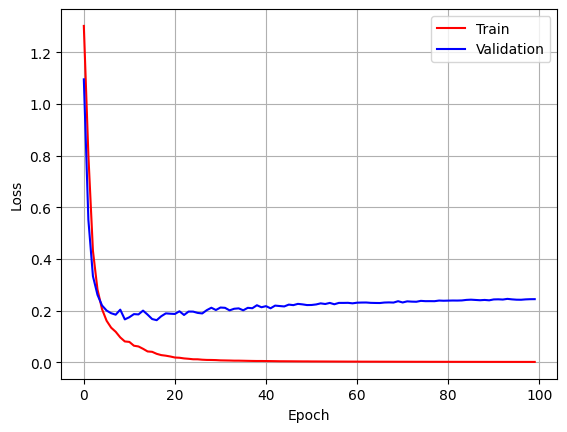

In [ ]:
plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

### Accuracy

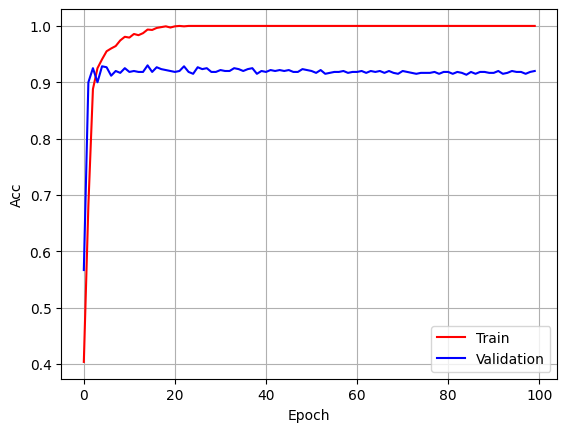

In [ ]:
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [ ]:
state_dict = model.state_dict()

In [ ]:
torch.save(state_dict, 'weights.pt')

In [ ]:
wb = torch.load('weights.pt')
model.load_state_dict(wb)

<All keys matched successfully>

# **Efficient way for set hyperparams 🔨**

In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
x_batch, y_batch = next(iter(train_loader))
yp = model(x_batch)
loss_fn(yp, y_batch)

tensor(1.4280, grad_fn=<NllLossBackward0>)

## Step 2: check backward path

Select 5 random batches and overfit the model

In [ ]:
mini_train_dataset, _ = random_split(train_dataset, (100, len(train_dataset)-100))
mini_loader = DataLoader(mini_train_dataset, 20, shuffle=True)

In [ ]:
for epoch in range(500):
    model, _, _ = train_one_epoch(model, mini_loader, loss_fn, optimizer, epoch)

## Step 3: select best lr

Train all data for one epoch

In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=..., weight_decay=...)

In [ ]:
for lr in [0.1, 0.01, 0.001, 0.0001]:
  model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  print(f'LR={lr}')
  for epoch in range(5):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=..., weight_decay=...)

In [ ]:
for lr in [0.1, 0.15, 0.2, 0.25, 0.3]:
  for wd in [0., 1e-4, 1e-5, 1e-6]:
    model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    print(f'LR={lr}, WD={wd}')
    for epoch in range(5):
      model, _, _ = train_one_epoch(model,
                                    train_loader,
                                    loss_fn,
                                    optimizer,
                                    epoch)
    print()
    # torch.save(...)

LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 105.63batch/s, accuracy=93.8, loss=0.186]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 107.88batch/s, accuracy=92.8, loss=0.212]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 84.07batch/s, accuracy=93.4, loss=0.208]



LR=0.1, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 91.00batch/s, accuracy=93.9, loss=0.203]



LR=0.15, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:01<00:00, 68.46batch/s, accuracy=90.7, loss=0.23]



LR=0.15, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:01<00:00, 64.15batch/s, accuracy=91.6, loss=0.218]



LR=0.15, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:02<00:00, 23.84batch/s, accuracy=92.8, loss=0.19]



LR=0.15, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 93.34batch/s, accuracy=93.4, loss=0.17]



LR=0.2, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 94.02batch/s, accuracy=89.1, loss=0.313]



LR=0.2, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 108.38batch/s, accuracy=90.2, loss=0.259]



LR=0.2, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 92.83batch/s, accuracy=90.4, loss=0.25]



LR=0.2, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 88.83batch/s, accuracy=87.4, loss=0.306]



LR=0.25, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 95.96batch/s, accuracy=89.4, loss=0.276]



LR=0.25, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 94.80batch/s, accuracy=87.4, loss=0.363]



LR=0.25, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 92.70batch/s, accuracy=89.8, loss=0.285]



LR=0.25, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 93.50batch/s, accuracy=90.5, loss=0.243] 



LR=0.3, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 91.82batch/s, accuracy=86, loss=0.321]



LR=0.3, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 89.63batch/s, accuracy=85.1, loss=0.398]



LR=0.3, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 94.12batch/s, accuracy=90.4, loss=0.243]



LR=0.3, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 90.13batch/s, accuracy=89.4, loss=0.253]

### Pretty table

In [ ]:
from prettytable import PrettyTable

l = [["Hassan", 21, "LUMS"], ["Ali", 22, "FAST"], ["Ahmed", 23, "UET"]]
table = PrettyTable(['Name', 'Age', 'University'])

for rec in l:
    table.add_row(rec)

print(table)

+--------+-----+------------+
|  Name  | Age | University |
+--------+-----+------------+
| Hassan |  21 |    LUMS    |
|  Ali   |  22 |    FAST    |
| Ahmed  |  23 |    UET     |
+--------+-----+------------+


## Step 5: train more epochs

In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=0.15, weight_decay=1e-5)

In [ ]:
num_epochs = 20

In [ ]:
best_valid_loss = torch.inf

In [ ]:
for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn)

  if loss_valid < best_valid_loss:
    torch.save(model, 'model.pt')
    best_valid_loss = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}\n')

Epoch 0: 100%|██████████| 70/70 [00:00<00:00, 100.64batch/s, accuracy=96, loss=0.106]


Valid: Loss = 0.3054, Acc = 0.8783



Epoch 1: 100%|██████████| 70/70 [00:00<00:00, 88.68batch/s, accuracy=94.4, loss=0.135]


Valid: Loss = 0.345, Acc = 0.8683



Epoch 2: 100%|██████████| 70/70 [00:00<00:00, 89.66batch/s, accuracy=94.3, loss=0.188]


Valid: Loss = 0.4065, Acc = 0.8467



Epoch 3: 100%|██████████| 70/70 [00:00<00:00, 91.78batch/s, accuracy=96.7, loss=0.0725]


Valid: Loss = 0.4162, Acc = 0.8533



Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 86.84batch/s, accuracy=97.1, loss=0.0766]


Valid: Loss = 0.2891, Acc = 0.885



Epoch 5: 100%|██████████| 70/70 [00:00<00:00, 89.06batch/s, accuracy=97.6, loss=0.0652]


Valid: Loss = 0.4412, Acc = 0.8533



Epoch 6: 100%|██████████| 70/70 [00:00<00:00, 86.41batch/s, accuracy=97.1, loss=0.0813]


Valid: Loss = 0.2771, Acc = 0.8983



Epoch 7: 100%|██████████| 70/70 [00:00<00:00, 97.75batch/s, accuracy=98.1, loss=0.0533]


Valid: Loss = 0.2672, Acc = 0.91



Epoch 8: 100%|██████████| 70/70 [00:00<00:00, 90.75batch/s, accuracy=99.6, loss=0.0235]


Valid: Loss = 0.2386, Acc = 0.9117



Epoch 9: 100%|██████████| 70/70 [00:00<00:00, 101.47batch/s, accuracy=98.6, loss=0.0375]


Valid: Loss = 0.253, Acc = 0.9033

